# VizDoom DefendTheLine


- Reward Shaping

----

# 1. Getting VizDoom

In [1]:
# Cloning repository
#!mkdir github
#!cd github & git clone https://github.com/mwydmuch/ViZDoom

In [5]:
import random
import time
import numpy as np
import os

import matplotlib.pyplot as plt

from vizdoom import *

In [9]:
# Setup Game
game = DoomGame()
game.load_config('github/VizDoom/scenarios/defend_the_line-s1.cfg')
game.init()

FileDoesNotExistException: File "github/VizDoom/scenarios/defend_the_line-s1.cfg | ./scenarios/github/vizdoom/scenarios/defend_the_line-s1.cfg | C:/Users/mikol/anaconda3/envs/RL38/lib/site-packages/vizdoom/scenarios/github/vizdoom/scenarios/defend_the_line-s1.cfg" does not exist.

In [2]:
# Set of all actions
actions = np.identity(3, dtype=np.uint8)
actions

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [ ]:
# Game with random actions
episodes = 1

for episode in range(episodes):
    game.new_episode()
    
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions), 4) # 4 = skipping 4 frames each iteration
        print("reward:", reward)
        time.sleep(0.02)
        
    print("Result:", game.get_total_reward())
    time.sleep(2)
    
game.close()

# 2. Converting Game To Gym Environment

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import cv2

In [3]:
class VizDoomGym(Env):
    """ Doom game class """
    
    def __init__(self, render=False, config='github/VizDoom/scenarios/defend_the_line.cfg'):
        """ Inicializing game """
        
        # Inherit from Env
        super().__init__()
        
        # Setup the game
        self.game = DoomGame()
        self.game.load_config(config)
        
        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(80,160,1), dtype=np.uint8)
        self.action_space = Discrete(3)
        
        # Game variables: HEALTH DAMAGE_TAKEN HITCOUNT
        self.damage_taken = 0
        self.hit_count = 0
    
    def step(self, action):
        """ Step in Environment """
        
        # Specify action and take step
        actions = np.identity(3)
        movement_reward = self.game.make_action(actions[action], 4)
        reward = 0
        
        # Get other things
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.greyscale(state)
            
            # ***Reward shaping***
            health, damage_taken, hit_count = self.game.get_state().game_variables
            # Calculate reward deltas
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hit_count_delta = hit_count - self.hit_count
            self.hit_count = hit_count
            
            reward = movement_reward + damage_taken_delta*20 + hit_count_delta*30 
            info = hit_count
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
            
        info = {"info": info}
        done = self.game.is_episode_finished()
            
        return state, reward, done, info
    
    
    def render():
        pass
    
    
    def reset(self):
        """ Reseting the Environment """
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.greyscale(state)
    
    
    def greyscale(self, observation):
        """ Applying greyscale, reshaping and removing HUD """
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state[:80,:]
    
    
    def close(self):
        """ Closing game """
        self.game.close()

# 3. View Game

In [6]:
# Opening the game
env = VizDoomGym(render=True)

In [7]:
# agent that tests if environment is setup correctly
from stable_baselines3.common import env_checker
env_checker.check_env(env)

In [8]:
# Action 2: shoot
env.step(2);

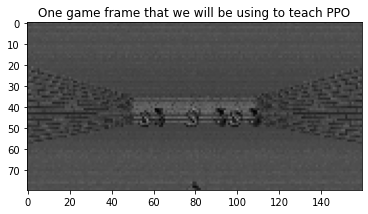

In [9]:
# Displaying evironment for learning 
state = env.reset()
plt.title("One game frame that we will be using to teach PPO")
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB));

In [10]:
env.close()

# 3. Setup Callback

In [4]:
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):
    """
    Callback class that save the model after n steps of iteration
    """
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
    
        return True

In [5]:
CHECKPOINT_DIR = './train/train_defend_the_line'
LOG_DIR = './logs/log_defend_the_line'

In [6]:
callback = TrainAndLoggingCallback(check_freq = 50_000, save_path=CHECKPOINT_DIR)

# 4. Training The Model Using Curriculum

In [10]:
# importing PPO algorithm
from stable_baselines3 import PPO

In [31]:
# Useless variable
env = VizDoomGym(config=f'github/VizDoom/scenarios/defend_the_line.cfg')

model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00003, n_steps=4096, clip_range=.2, gamma=.98, gae_lambda=.98)
# the more complex environment(like Dota or Cs-GO) the higher n_steps, lower learning rate and more iterations

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [19]:
model.learn(total_timesteps=300_000, callback=callback)

Logging to ./logs/log_defend_the_line\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 141      |
|    ep_rew_mean     | -36.3    |
| time/              |          |
|    fps             | 31       |
|    iterations      | 1        |
|    time_elapsed    | 128      |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 134         |
|    ep_rew_mean          | -18.6       |
| time/                   |             |
|    fps                  | 38          |
|    iterations           | 2           |
|    time_elapsed         | 213         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008022685 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 4.8         |
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 11          |
|    time_elapsed         | 963         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.028459482 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.0611      |
|    learning_rate        | 3e-05       |
|    loss                 | 2.97e+04    |
|    n_updates            | 100         |
|    policy_gradient_loss | 0.00199     |
|    value_loss           | 8.33e+04    |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 119     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 104         |
|    ep_rew_mean          | 5.95        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 21          |
|    time_elapsed         | 1768        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.006723264 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.308       |
|    learning_rate        | 3e-05       |
|    loss                 | 3.6e+04     |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.00575     |
|    value_loss           | 8.1e+04     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 109   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 110         |
|    ep_rew_mean          | 5.88        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 31          |
|    time_elapsed         | 2597        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.011755776 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.947      |
|    explained_variance   | 0.447       |
|    learning_rate        | 3e-05       |
|    loss                 | 3.05e+04    |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.00551     |
|    value_loss           | 7.21e+04    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 130   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 156         |
|    ep_rew_mean          | 16.2        |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 41          |
|    time_elapsed         | 3444        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.016979605 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.737      |
|    explained_variance   | 0.31        |
|    learning_rate        | 3e-05       |
|    loss                 | 2.89e+04    |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.00514     |
|    value_loss           | 5.12e+04    |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 155     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 178          |
|    ep_rew_mean          | 18.6         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 51           |
|    time_elapsed         | 4319         |
|    total_timesteps      | 208896       |
| train/                  |              |
|    approx_kl            | 0.0058155246 |
|    clip_fraction        | 0.0543       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.426       |
|    explained_variance   | 0.336        |
|    learning_rate        | 3e-05        |
|    loss                 | 2.77e+04     |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.000579    |
|    value_loss           | 4.22e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 193         |
|    ep_rew_mean          | 16.6        |
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 61          |
|    time_elapsed         | 5211        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.003552279 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.35       |
|    explained_variance   | 0.36        |
|    learning_rate        | 3e-05       |
|    loss                 | 1.84e+04    |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.00094     |
|    value_loss           | 4.1e+04     |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 191 

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 165           |
|    ep_rew_mean          | 10.7          |
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 71            |
|    time_elapsed         | 6199          |
|    total_timesteps      | 290816        |
| train/                  |               |
|    approx_kl            | 0.00018156461 |
|    clip_fraction        | 0.00176       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0269       |
|    explained_variance   | 0.535         |
|    learning_rate        | 3e-05         |
|    loss                 | 1.49e+04      |
|    n_updates            | 700           |
|    policy_gradient_loss | -0.000103     |
|    value_loss           | 2.77e+04      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

### INFO

ep_len_mean = mean of frames that it takes to end episode\
ep_rew_mean = mean of episode rewards\
approx_kl = diffrence between current policy and previous policy\
clip_fraction = similar to approx_kl\
explained_variance = how our critic is correctly predicting the reward or future


#### to check results using tensorflow dashboard:
 "open cmd"\
 "go to folder"\
 activate\
 cd logs\
 cd PPO_3 "latest PPO"\
 tensorboard --logdir=.\
 "copy given link and paste into browser" (link looks like this http://localhost:6006/)

# 5. Testing The Model

In [9]:
# Importing eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Testing each model 100 times

env = VizDoomGym()

for i in range(10_000, 110_000, 10_000):
    # Reloading best model
    model = PPO.load(f'./train/train_defend_the_line/best_model_{i}')
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
    print(i, "=", mean_reward)

env.close()

In [13]:
# Displaying how agent plays the game

model = PPO.load(f'./train/train_defend_the_line/best_model_300000')
env = VizDoomGym(render=1)

for episode in range(4):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.2)
        total_reward += reward
    
    print(f"Total reward for episode {episode+1} is {total_reward}")
    time.sleep(2)
    
env.close()

Total reward for episode 1 is -1485.0


KeyboardInterrupt: 

In [14]:
env.close()

In [ ]:
# As we can see our model found the most optimal strategy. to just aim at one guy and shoot..